# NOM & PRENOM : LONMADON Géofroid

# Assignment 2 - Collective communications 

# Exercise 1: Parallel Monte Carlo for PI

Implement a parallel version of Monte Carlo using the function above:

Ensure your program works correctly if N is not an exact multiple of the number of processes P

In [68]:
%%file mcpi.py

from mpi4py import MPI
import random

def compute_points(INTERVAL):
    
    random.seed(42)  
    
    circle_points= 0
    total_points=0

    # Total Random numbers generated= possible x 
    # values* possible y values 
    for i in range(INTERVAL**2): 
      
        # Randomly generated x and y values from a 
        # uniform distribution 
        # Range of x and y values is -1 to 1 
        
        rand_x= random.uniform(-1, 1) 
        rand_y= random.uniform(-1, 1) 
      
        # Distance between (x, y) from the origin 
        origin_dist= rand_x**2 + rand_y**2
      
        # Checking if (x, y) lies inside the circle 
        if origin_dist<= 1: 
            circle_points+= 1
        
        total_points+=1
    
    return circle_points, total_points

COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()

if RANK==0:
    INTERVAL = 1000
    inter = INTERVAL // SIZE
    reste = INTERVAL % SIZE
    intervals = [inter for i in range(SIZE)]

    for i in range(reste):
        intervals[i] += 1
        
else:
    intervals = None

interval_loc = COMM.scatter(intervals, root=0)
    
print(f"I, process {RANK}, I have {interval_loc}")
    
numbers = compute_points(interval_loc)
circle_points = COMM.reduce(numbers[0], op=MPI.SUM, root=0)
total_points = COMM.reduce(numbers[1], op=MPI.SUM, root=0)

if RANK==0:
    pi = 4*(circle_points/total_points)
    print(f"I, process {RANK}, pi is {pi}")

Overwriting mcpi.py


In [69]:
!mpiexec -n 3 python mcpi.py

I, process 1, I have 333
I, process 2, I have 333
I, process 0, I have 334
I, process 0, pi is 3.1414617170765657


# Exercise 2 Parallel Stochastic Gradient Descent for Linear Regression

Implement a parallel version of Stochastic Gradient Descent (SGD) for linear regression using MPI. The goal is to distribute the dataset across multiple MPI processes, perform local updates (gradient descent steps) on each process, and periodically synchronize the model parameters across all processes.

Ensure your program works correctly if N is not an exact multiple of the number of processes P

Dataset: Use a synthetic dataset for simplicity. You can generate a dataset with a single feature and a linear relationship with the target variable. For example, you can model the relationship y = 2x + noise, where noise is some Gaussian noise.

In [70]:
%%file sgd4lr.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()

def compute_gradient(data, labels, weight):
    predictions = data * weight
    errors = predictions - labels
    gradient = 2 * np.dot(data, errors) / len(data)
    return gradient

def generate_data(n_samples, with_noise = True):
    x = np.random.rand(n_samples)
    y = 2*x + np.random.normal(loc=0, scale=1, size=len(x)) if with_noise else 0
    return x,y

np.random.seed(42)
itrs = 100
eps = 0.001

if RANK==0:
    n_samples = 100000
    x,y = generate_data(n_samples, True)
    x_loc = np.array_split(x,SIZE)
    y_loc = np.array_split(y,SIZE)
    
    weight = np.random.rand()

else:
    x_loc = None
    y_loc = None
    weight = None
    
x_loc = COMM.scatter(x_loc, root=0)
y_loc = COMM.scatter(y_loc, root=0)
weight = COMM.bcast(weight, root=0)

for i in range(itrs):
    gradient = compute_gradient(x_loc, y_loc, weight)
    sum_gradient = COMM.allreduce(gradient, op=MPI.SUM)
    COMM.Barrier()
    weight -= eps*sum_gradient
    
COMM.Barrier()

if RANK==0:
    print(f"Final model parameters (weight) is {weight}")
    

Overwriting sgd4lr.py


In [71]:
!mpiexec -n 3 python sgd4lr.py

Final model parameters (weight) is 0.7262866557328479


# Exercise 3: Matrix vector product

1. Use the code above to implement the MPI version of matrix-vector multiplication.

2. Ensure your program works correctly if N is not an exact multiple of the number of processes P

3. Process 0 compares the result with the dot product.

4. Plot the scalability of your implementation.



In [2]:
%%file exercise3MVP.py

import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numba import njit
from mpi4py import MPI

''' This program compute parallel csc matrix vector multiplication using mpi '''

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

seed(42)

def matrixVectorMult(A, b, x):
    
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]

    return 0

########################initialize matrix A and vector b ######################
#matrix sizes
SIZE = 1000
Local_size = SIZE//nbOfproc
reste = SIZE % nbOfproc

if RANK < reste:
    Local_size += 1

# counts = block of each proc
counts = COMM.allgather(Local_size*SIZE)
counts=np.array(counts)

if RANK == 0:
    """A = np.array([
    [1, 2, 0, 0],
    [0, 3, 4, 0],
    [5, 0, 0, 6],
    [0, 0, 7, 8]], dtype=np.double)"""
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    b = rand(SIZE)
else :
    A = None
    b = None
    
b = COMM.bcast(b, root=0)

#########Send b to all procs and scatter A (each proc has its own local matrix#####
LocalMatrix = np.zeros((Local_size, SIZE), dtype=np.double)
# Scatter the matrix A
COMM.Scatterv([A, counts, MPI.DOUBLE], LocalMatrix, root=0)
print(f"{RANK}, got this\n {LocalMatrix} \n")

#####################Compute A*b locally#######################################
LocalX = np.zeros(Local_size)
#print(f"{RANK}, got this {LocalX} \n")


start = MPI.Wtime()
matrixVectorMult(LocalMatrix, b, LocalX)
stop = MPI.Wtime()

maxTime = COMM.reduce((stop - start)*1000, op=MPI.MAX, root=0)

if RANK==0:
    with open('CPU_time.txt', 'a') as fichier:
        fichier.write(str(maxTime)+" ")

if RANK == 0:
    print("CPU time of parallel multiplication is ", (stop - start)*1000)

##################Gather te results ###########################################
# sendcouns = local size of result
sendcounts = COMM.gather(Local_size, root=0)
if RANK == 0:
    X = np.zeros(SIZE)
else :
    X = None

COMM.Gatherv(LocalX, [X,sendcounts], root=0)

# Gather the result into X
##################Print the results ###########################################
if RANK == 0 :
    #print(sendcounts)
    X_ = A.dot(b)
    print("The result of A*b using dot is :", np.max(X_ - X))
    #print("The result of A*b using dot is :", round(np.max(X_ - np.array(X).reshape(-1))))
    #print("The result of A*b using parallel version is :", X)



Overwriting exercise3MVP.py


In [5]:
!mpiexec -n 4 python3 exercise3MVP.py

Python est introuvable. Exécutez sans argument pour procéder à l
Python est introuvable. Exécutez sans argument pour procéder à l
Python est introuvable. Exécutez sans argument pour procéder à l
Python est introuvable. Exécutez sans argument pour procéder à l


In [23]:
import numpy as np
import matplotlib.pyplot as plt
nombres = [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 17, 19, 20]
CPUtimes = np.array([330.754788, 173.673393, 120.210992, 91.672748, 73.98903299999999, 54.529973000000005, 42.648274, 36.463613, 32.577387, 28.473326, 24.806604999999998, 21.257331, 21.141844])
SPDP = CPUtimes[0]/CPUtimes

/tmp/ipykernel_235952/1284323640.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


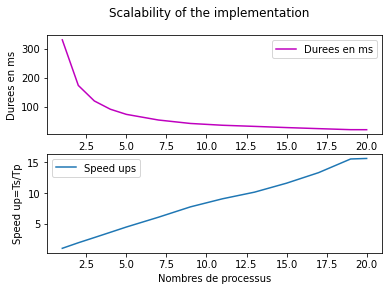

In [25]:
plt.suptitle('Scalability of the implementation')
plt.xticks(nombres)

plt.subplot(2,1,1)
plt.xlabel('Nombres de processus')
plt.ylabel('Durees en ms')
plt.plot(nombres, CPUtimes,label='Durees en ms',color='m')
plt.legend()



plt.subplot(2,1,2)
plt.xlabel('Nombres de processus')
plt.ylabel('Speed up=Ts/Tp')
plt.plot(nombres, SPDP,label='Speed ups')
plt.legend()
plt.show()